# Visualizing tree-based regressors

([View this notebook in Colab](https://colab.research.google.com/github/parrt/dtreeviz/blob/master/notebooks/dtreeviz_sklearn_visualisations.ipynb))

The [dtreeviz](https://github.com/parrt/dtreeviz) library is designed to help machine learning practitioners visualize and interpret decision trees and decision-tree-based models, such as gradient boosting machines.  

The purpose of this notebook is to illustrate the main capabilities and functions of the dtreeviz API. To do that, we will use scikit-learn and the toy but well-known Titanic data set for illustrative purposes.  Currently, dtreeviz supports the following decision tree libraries:

* [scikit-learn](https://scikit-learn.org/stable)
* [XGBoost](https://xgboost.readthedocs.io/en/latest)
* [Spark MLlib](https://spark.apache.org/mllib/)
* [LightGBM](https://lightgbm.readthedocs.io/en/latest/)
* [Tensorflow](https://www.tensorflow.org/decision_forests)

To interopt with these different libraries, dtreeviz uses an adaptor object, obtained from function `dtreeviz.model()`, to extract model information necessary for visualization. Given such an adaptor object, all of the dtreeviz functionality is available to you using the same programmer interface. The basic dtreeviz usage recipe is:

1. Import dtreeviz and your decision tree library
2. Acquire and load data into memory
3. Train a classifier or regressor model using your decision tree library
4. Obtain a dtreeviz adaptor model using<br>`viz_model = dtreeviz.model(your_trained_model,...)`
5. Call dtreeviz functions, such as<br>`viz_model.view()` or `viz_model.explain_prediction_path(sample_x)`

The four categories of dtreeviz functionality are:

1. Tree visualizations
2. Prediction path explanations
3. Leaf information
4. Feature space exploration

We have grouped code examples by [classifiers](#Classifiers) and [regressors](#Regressors), with a follow up section on [partitioning feature space](#Feature-Space-Partitioning).

*These examples require dtreeviz 2.0 or above because the code uses the new API introduced in 2.0.*

## Setup

In [1]:
import sys
import os

In [2]:
%config InlineBackend.figure_format = 'retina' # Make visualizations look good
#%config InlineBackend.figure_format = 'svg'
%matplotlib inline

if 'google.colab' in sys.modules:
  !pip install -q dtreeviz

In [3]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

import dtreeviz

random_state = 1234 # get reproducible trees

## Load Sample Data

In [4]:
dataset_url = "https://raw.githubusercontent.com/parrt/dtreeviz/master/data/titanic/titanic.csv"
dataset = pd.read_csv(dataset_url)
# Fill missing values for Age
dataset.fillna({"Age":dataset.Age.mean()}, inplace=True)
# Encode categorical variables
dataset["Sex_label"] = dataset.Sex.astype("category").cat.codes
dataset["Cabin_label"] = dataset.Cabin.astype("category").cat.codes
dataset["Embarked_label"] = dataset.Embarked.astype("category").cat.codes

To demonstrate regressor tree visualization, we start by creating a regressors model that predicts age instead of survival:

In [5]:
features_reg = ["Pclass", "Fare", "Sex_label", "Cabin_label", "Embarked_label", "Survived"]
target_reg = "Age"

tree_regressor = DecisionTreeRegressor(max_depth=3, random_state=random_state, criterion="mae")
tree_regressor.fit(dataset[features_reg].values, dataset[target_reg].values)

DecisionTreeRegressor(criterion='mae', max_depth=3, random_state=1234)

## Initialize dtreeviz model (adaptor)

In [6]:
viz_rmodel = dtreeviz.model(model=tree_regressor,
                            X_train=dataset[features_reg],
                            y_train=dataset[target_reg],
                            feature_names=features_reg,
                            target_name=target_reg)

## Tree structure visualisations

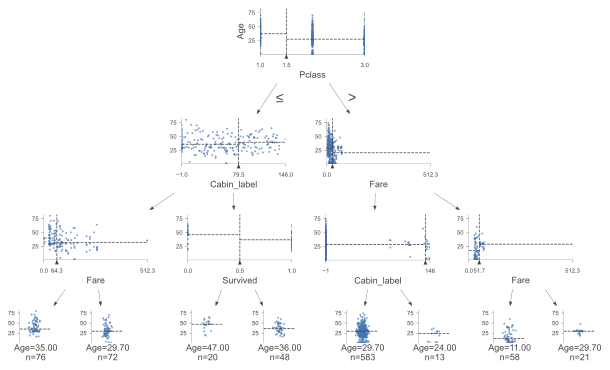

In [7]:
viz_rmodel.view()

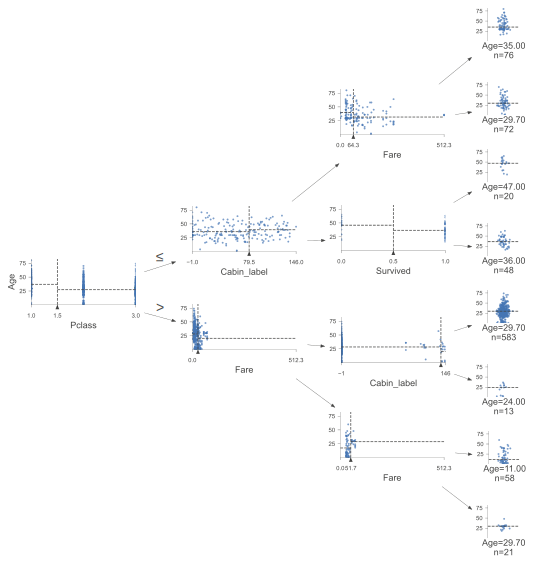

In [8]:
viz_rmodel.view(orientation="LR")

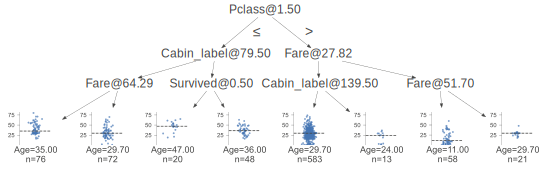

In [9]:
viz_rmodel.view(fancy=False)

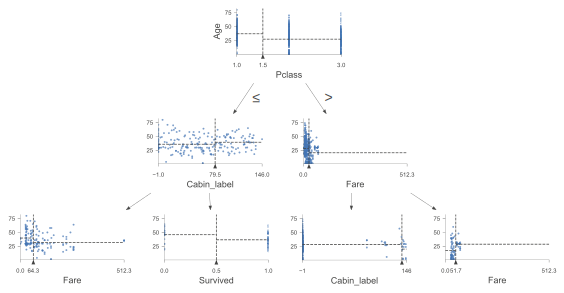

In [10]:
viz_rmodel.view(depth_range_to_display=(0, 2))

## Prediction path explanations

In [11]:
x = dataset[features_reg].iloc[10]
x

Pclass              3.0
Fare               16.7
Sex_label           0.0
Cabin_label       145.0
Embarked_label      2.0
Survived            1.0
Name: 10, dtype: float64

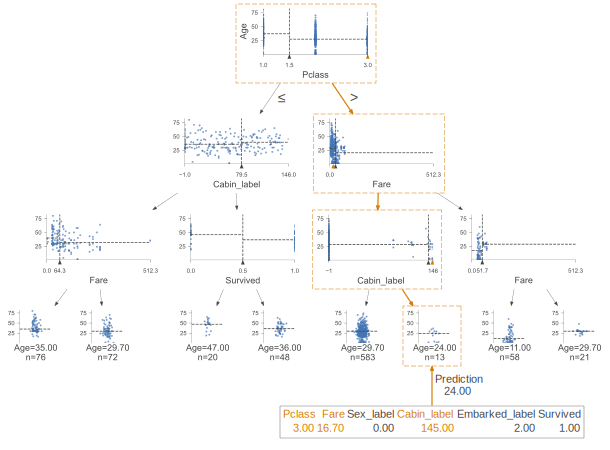

In [12]:
viz_rmodel.view(x = x)

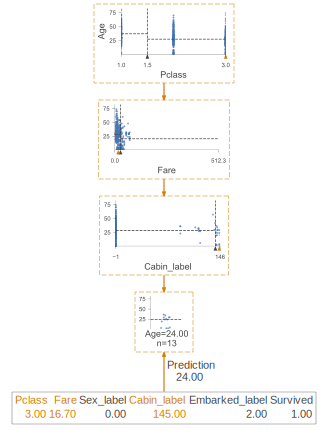

In [13]:
viz_rmodel.view(show_just_path=True, x = x)

In [14]:
print(viz_rmodel.explain_prediction_path(x))

1.5 <= Pclass 
Fare < 27.82
139.5 <= Cabin_label 



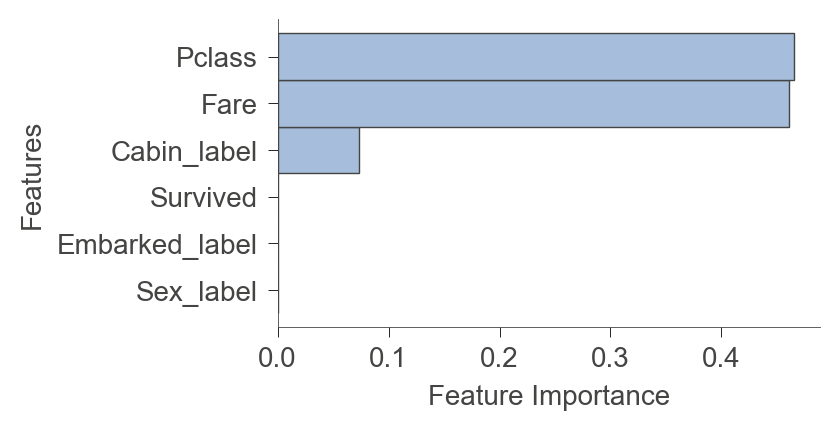

In [15]:
viz_rmodel.instance_feature_importance(x, figsize=(3.5,2))

## Leaf info

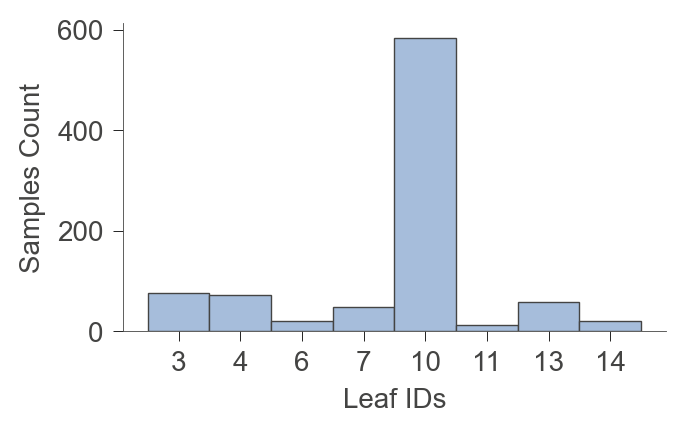

In [16]:
viz_rmodel.leaf_sizes(figsize=(3.5,2))

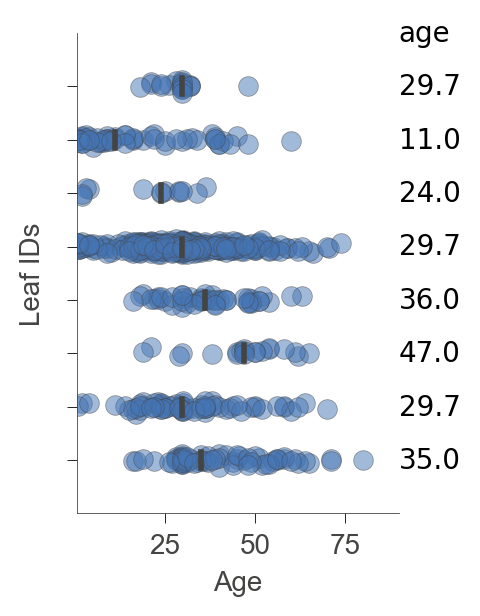

In [17]:
viz_rmodel.rtree_leaf_distributions()

In [18]:
viz_rmodel.node_stats(node_id=4)

Pclass        Fare  Sex_label  Cabin_label  Embarked_label  Survived
count    72.0        72.0       72.0         72.0            72.0      72.0
mean      1.0  152.167936   0.347222        39.25        0.916667  0.763889
std       0.0   97.808005   0.479428    26.556742        1.031203  0.427672
min       1.0        66.6        0.0         -1.0            -1.0       0.0
25%       1.0     83.1583        0.0        20.75             0.0       1.0
50%       1.0       120.0        0.0         40.0             0.0       1.0
75%       1.0    211.3375        1.0         63.0             2.0       1.0
max       1.0    512.3292        1.0         79.0             2.0       1.0

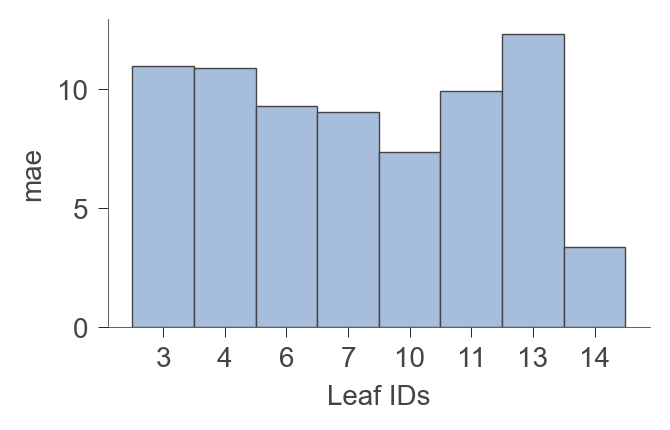

In [19]:
viz_rmodel.leaf_purity(figsize=(3.5,2))

## Partitioning

To demonstrate regression, let's load a toy Cars data set and visualize the partitioning of univariate and bivariate feature spaces.

In [27]:
dataset_url = "https://raw.githubusercontent.com/parrt/dtreeviz/master/data/cars.csv"
df_cars = pd.read_csv(dataset_url)
X = df_cars.drop('MPG', axis=1)
y = df_cars['MPG']
features = list(X.columns)

In [28]:
dtr_cars = DecisionTreeRegressor(max_depth=3, criterion="mae")
dtr_cars.fit(X.values, y.values)

DecisionTreeRegressor(criterion='mae', max_depth=3)

In [29]:
viz_rmodel = dtreeviz.model(dtr_cars, X, y,
                            feature_names=features,
                            target_name='MPG')

The following visualization illustrates how the decision tree breaks up the `WGT` (car weight) in order to get relatively pure `MPG` (miles per gallon) target values.

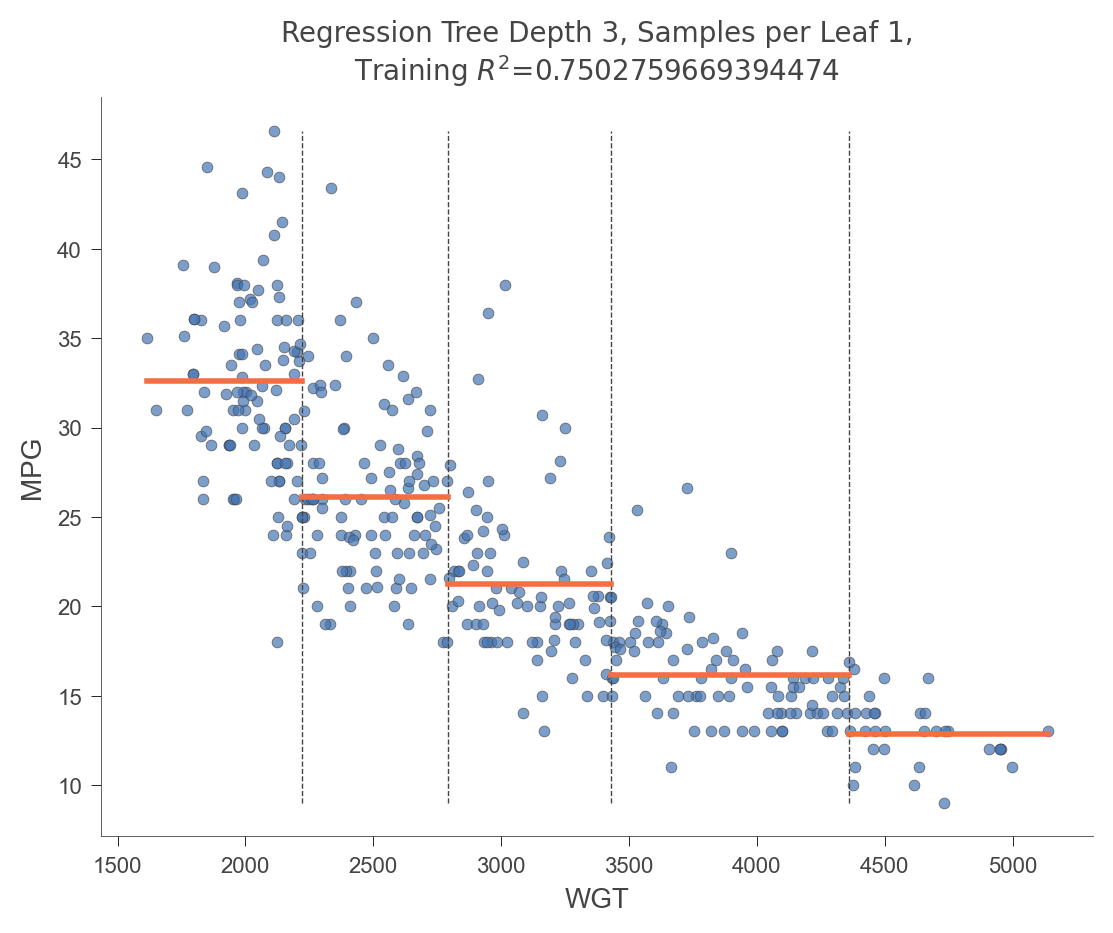

In [30]:
viz_rmodel.rtree_feature_space(features=['WGT'])

In order to visualize two-dimensional feature space, we can draw in three dimensions:

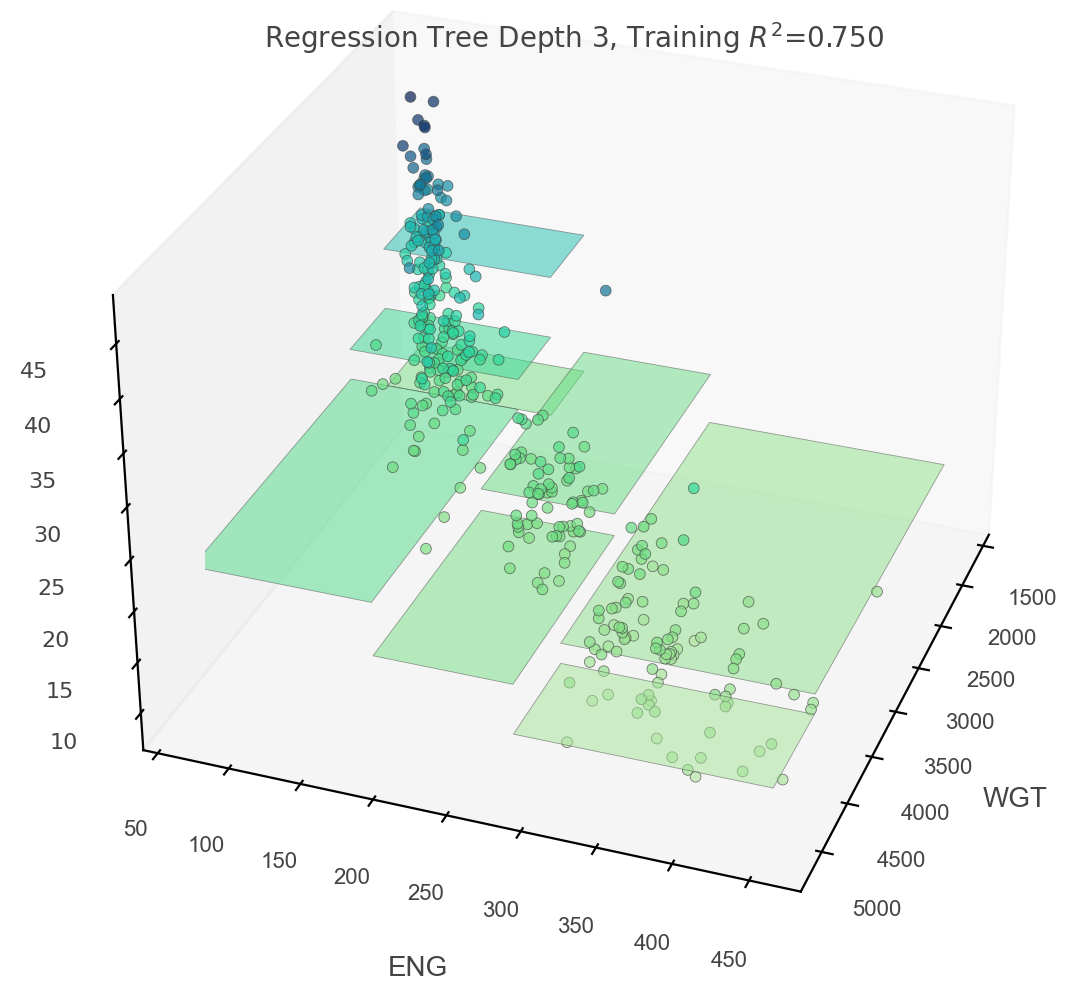

In [31]:
viz_rmodel.rtree_feature_space3D(features=['WGT','ENG'],
                                 fontsize=10,
                                 elev=30, azim=20,
                                 show={'splits', 'title'},
                                 colors={'tessellation_alpha': .5})

Equivalently, we can show a heat map as if we were looking at the three-dimensional plot from the top down:

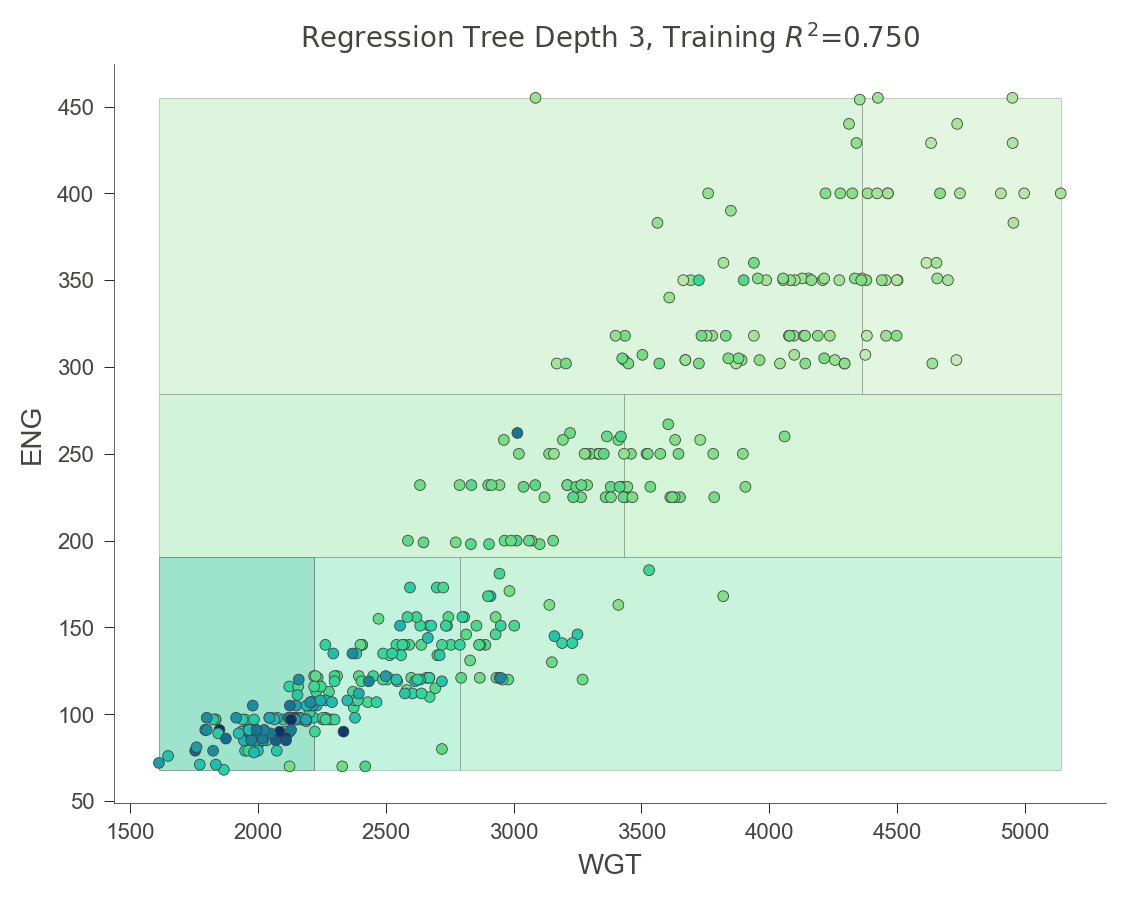

In [32]:
viz_rmodel.rtree_feature_space(features=['WGT','ENG'])